<a href="https://colab.research.google.com/github/vjmiyagi/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [10]:
# Import Libraries

import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

# Grab the file from UCI
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-03-19 12:40:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.1’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-03-19 12:40:13 (284 KB/s) - ‘house-votes-84.data.1’ saved [18171/18171]



In [11]:
# Load data into df

df=pd.read_csv('house-votes-84.data',names=['party','handicapped-infants',
                                            'water-project','budget',
                                            'physician-fee-freeze',
                                            'el-salvador-aid',
                                            'religious-groups',
                                            'anti-satellite-ban',
                                            'aid-to-contras','mx-missile',
                                            'immigration','synfuels',
                                            'education','right-to-sue','crime',
                                            'duty-free','south-africa'])
print(df.shape), df.head()

(435, 17)


(None,
         party handicapped-infants water-project  ... crime duty-free south-africa
 0  republican                   n             y  ...     y         n            y
 1  republican                   n             y  ...     y         n            ?
 2    democrat                   ?             y  ...     y         n            n
 3    democrat                   n             y  ...     n         n            y
 4    democrat                   y             y  ...     y         y            y
 
 [5 rows x 17 columns])

In [14]:
# Work with 0 in place of NaN values
df = df.replace({'y':1, 'n':0,'?':0})

df.head()
df.shape

(435, 17)

In [0]:
# Break out the republicans and democrats into dataframes
# Essentially working with 3 dataframes
# Entire House, Just Dems and Just Reps
house = df
rep = df[df['party'] =='republican']
dem = df[df['party'] =='democrat']

In [36]:
print(house.head())
print(dem.head())
rep.head()


        party  handicapped-infants  ...  duty-free  south-africa
0  republican                    0  ...          0             1
1  republican                    0  ...          0             0
2    democrat                    0  ...          0             0
3    democrat                    0  ...          0             1
4    democrat                    1  ...          1             1

[5 rows x 17 columns]
      party  handicapped-infants  water-project  ...  crime  duty-free  south-africa
2  democrat                    0              1  ...      1          0             0
3  democrat                    0              1  ...      0          0             1
4  democrat                    1              1  ...      1          1             1
5  democrat                    0              1  ...      1          1             1
6  democrat                    0              1  ...      1          1             1

[5 rows x 17 columns]


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0
7,republican,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,1
8,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
10,republican,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0


# GLOSSARY

panda as pd\
numpy as np\
scipy stats as st\
matplotlib.pyplot as plt\

df = dataframe\
house = dataframe of entire house of representatives\
dem = members of the house that are democrat\
rep = members of the house that are republican
ci = confidence interval
c = confidence
m = mean
n = number of observations
se = standard error




# Generate and numerically represent a confidence interval

In [0]:
# Define function to calculate confidence interval
# GLOSSARY: ci = confidence interval, c = confidence
# m = mean, n = number of obersavtions
# se = standard error
# intvl = interval

def ci(df, c=0.95):
    m = np.mean(df)
    n = len(df)
    se = st.sem(df)
    intvl = se * st.t.ppf((1+c)/2.0,n-1)
    return (m-1, m, m+1)


In [139]:
df = house
bill = 'budget'
ci(df[bill])

(-0.41839080459770117, 0.5816091954022988, 1.5816091954022988)

In [140]:
# For loop to run through tables

t = [['House', house],['Dems', dem], ['Reps', rep]]
for x in t:
    print(x[0])
    print(x[1].head())

House
        party  handicapped-infants  ...  duty-free  south-africa
0  republican                    0  ...          0             1
1  republican                    0  ...          0             0
2    democrat                    0  ...          0             0
3    democrat                    0  ...          0             1
4    democrat                    1  ...          1             1

[5 rows x 17 columns]
Dems
      party  handicapped-infants  water-project  ...  crime  duty-free  south-africa
2  democrat                    0              1  ...      1          0             0
3  democrat                    0              1  ...      0          0             1
4  democrat                    1              1  ...      1          1             1
5  democrat                    0              1  ...      1          1             1
6  democrat                    0              1  ...      1          1             1

[5 rows x 17 columns]
Reps
         party  handicapped-infants  .

In [216]:
# Display the confidence intervals for all three dataframes
print("Confidence Intervals:")
for x in t:
    df=x[1]
    
    print()
    print(x[0], ci(df[bill]))
    print()

Confidence Intervals:

House (-0.5931034482758621, 0.4068965517241379, 1.4068965517241379)


Dems (-0.947565543071161, 0.052434456928838954, 1.0524344569288389)


Reps (-0.029761904761904767, 0.9702380952380952, 1.9702380952380953)



## Graphically (with a plot) represent the confidence interval

In [0]:
bill = 'budget'

# Define function to plot graphs 

def ci_graph(bill):

    txt = "Considering the House bill on " + str(bill)
    txt = txt.center(55)
    txt2= "The total vote was " + str(house[bill].sum())
    txt2= txt2.center(55)
    print(txt)
    print()
    print(txt2)
    
    for x in t:
        txt = "The total"
        df = x[1]
        a = df[bill].to_numpy()

        low, m, high = ci(df[bill])
        df[bill].plot.density()

        class color:
            PURPLE = '\033[95m'
            CYAN = '\033[96m'
            DARKCYAN = '\033[36m'
            BLUE = '\033[94m'
            GREEN = '\033[92m'
            YELLOW = '\033[93m'
            RED = '\033[91m'
            BOLD = '\033[1m'
            UNDERLINE = '\033[4m'
            END = '\033[0m'

        low, m, high = ci(house[bill])
        plt.axvline(x=low, color='red')
        plt.axvline(x=m, color='green')
        plt.axvline(x=high, color='red')        
        plt.show()


LIST OF BILLS:\
'water-project', 'budget', 'physician-fee-freeze', 'el-salvador-aid', 
'religious-groups', 'anti-satellite-ban', 'aid-to-contras', 'mx-missile', 'immigration', 'synfuels', 'education', 'right-to-sue',  'crime', 'duty-free', 'south-africa'

In [194]:
house['budget'].sum()

253

          Considering the House bill on budget         

                 The total vote was 253                
['House',           party  handicapped-infants  ...  duty-free  south-africa
0    republican                    0  ...          0             1
1    republican                    0  ...          0             0
2      democrat                    0  ...          0             0
3      democrat                    0  ...          0             1
4      democrat                    1  ...          1             1
..          ...                  ...  ...        ...           ...
430  republican                    0  ...          0             1
431    democrat                    0  ...          0             1
432  republican                    0  ...          0             1
433  republican                    0  ...          0             1
434  republican                    0  ...          0             0

[435 rows x 17 columns]]


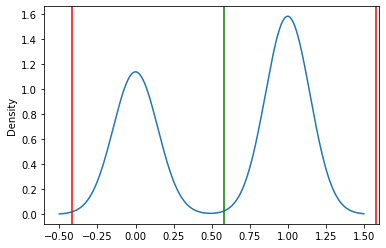

['Dems',         party  handicapped-infants  ...  duty-free  south-africa
2    democrat                    0  ...          0             0
3    democrat                    0  ...          0             1
4    democrat                    1  ...          1             1
5    democrat                    0  ...          1             1
6    democrat                    0  ...          1             1
..        ...                  ...  ...        ...           ...
425  democrat                    0  ...          1             0
426  democrat                    1  ...          1             1
428  democrat                    0  ...          1             1
429  democrat                    1  ...          1             1
431  democrat                    0  ...          0             1

[267 rows x 17 columns]]


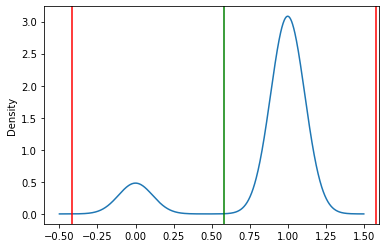

['Reps',           party  handicapped-infants  ...  duty-free  south-africa
0    republican                    0  ...          0             1
1    republican                    0  ...          0             0
7    republican                    0  ...          0             1
8    republican                    0  ...          0             1
10   republican                    0  ...          0             0
..          ...                  ...  ...        ...           ...
427  republican                    0  ...          0             1
430  republican                    0  ...          0             1
432  republican                    0  ...          0             1
433  republican                    0  ...          0             1
434  republican                    0  ...          0             0

[168 rows x 17 columns]]


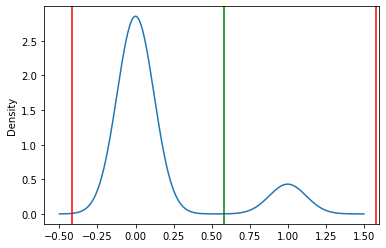

In [219]:
# Looking first at the budget bill -- Dems supported more than Reps

bill = 'budget'
ci_graph(bill)

   Considering the House bill on physician-fee-freeze  

                 The total vote was 177                
['House',           party  handicapped-infants  ...  duty-free  south-africa
0    republican                    0  ...          0             1
1    republican                    0  ...          0             0
2      democrat                    0  ...          0             0
3      democrat                    0  ...          0             1
4      democrat                    1  ...          1             1
..          ...                  ...  ...        ...           ...
430  republican                    0  ...          0             1
431    democrat                    0  ...          0             1
432  republican                    0  ...          0             1
433  republican                    0  ...          0             1
434  republican                    0  ...          0             0

[435 rows x 17 columns]]


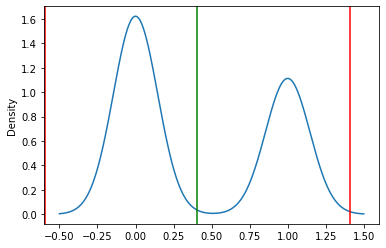

['Dems',         party  handicapped-infants  ...  duty-free  south-africa
2    democrat                    0  ...          0             0
3    democrat                    0  ...          0             1
4    democrat                    1  ...          1             1
5    democrat                    0  ...          1             1
6    democrat                    0  ...          1             1
..        ...                  ...  ...        ...           ...
425  democrat                    0  ...          1             0
426  democrat                    1  ...          1             1
428  democrat                    0  ...          1             1
429  democrat                    1  ...          1             1
431  democrat                    0  ...          0             1

[267 rows x 17 columns]]


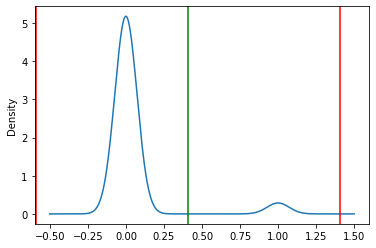

['Reps',           party  handicapped-infants  ...  duty-free  south-africa
0    republican                    0  ...          0             1
1    republican                    0  ...          0             0
7    republican                    0  ...          0             1
8    republican                    0  ...          0             1
10   republican                    0  ...          0             0
..          ...                  ...  ...        ...           ...
427  republican                    0  ...          0             1
430  republican                    0  ...          0             1
432  republican                    0  ...          0             1
433  republican                    0  ...          0             1
434  republican                    0  ...          0             0

[168 rows x 17 columns]]


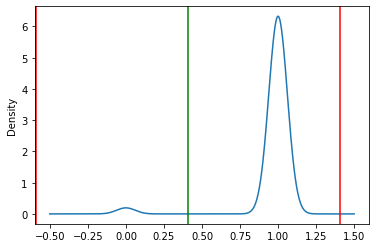

In [214]:
# Looking first at the budget bill -- Dems supported more than Reps

bill = 'physician-fee-freeze'
ci_graph(bill)

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)